<a href="https://colab.research.google.com/github/ainkun/DLSCA_test/blob/main/DLSCA_Try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/google/scaaml.git


In [ ]:
!wget https://storage.googleapis.com/scaaml-public/scaaml_intro/datasets.zip

In [ ]:
!unzip /content/datasets.zip

In [ ]:
!wget https://storage.googleapis.com/scaaml-public/scaaml_intro/models.zip

In [ ]:
!unzip models.zip

In [6]:
!mv datasets /content/scaaml/scaaml_intro/

In [7]:
!mv models /content/scaaml/scaaml_intro/

In [ ]:
!pip install -r /content/scaaml/requirements.txt

In [ ]:
!sudo apt install tensorrt

In [ ]:
!cd /content/scaaml && python3 /content/scaaml/setup.py install

In [ ]:
!cd /content/scaaml/scaaml_intro && python /content/scaaml/scaaml_intro/train.py -c /content/scaaml/scaaml_intro/config/stm32f415_tinyaes.json

In [ ]:
from glob import glob

pattern = f"/content/scaaml/scaaml_intro/datasets/tinyaes/train*"
num_shards=256

def list_shards(file_pattern, num_shards):
    return glob(file_pattern)[:num_shards]


In [ ]:
list_shards(pattern,num_shards)

['/content/scaaml/scaaml_intro/datasets/tinyaes/train']

In [ ]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from tensorflow.keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix
from scaaml.utils import tf_cap_memory, from_categorical
from scaaml.model import get_models_by_attack_point, get_models_list, load_model_from_disk
from scaaml.intro.generator import list_shards, load_attack_shard
from scaaml.utils import hex_display, bytelist_to_hex

In [ ]:
target = 'stm32f415_tinyaes'
tf_cap_memory()
target_config = json.loads(open("/content/scaaml/scaaml_intro/config/" + target + '.json').read())
BATCH_SIZE = target_config['batch_size']
TRACE_LEN = target_config['max_trace_len']

Physical devices cannot be modified after being initialized


In [ ]:
available_models = get_models_by_attack_point(target_config)


Attack point    status      Num available models
--------------  --------  ----------------------
sub_bytes_out   complete                      16


In [ ]:
DATASET_GLOB = "/content/scaaml/scaaml_intro/datasets/%s/test/*" % target_config['algorithm']
shard_paths  = list_shards(DATASET_GLOB, 10)

In [ ]:
# let's select an attack point that have all the needed models -- Key is not a good target: it doesn't work
ATTACK_POINT = 'sub_bytes_out'

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 0

# load model
print(available_models[ATTACK_POINT][ATTACK_BYTE])
model = load_model_from_disk("/content/scaaml/scaaml_intro/models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_0-len_20000")

models/stm32f415-tinyaes-cnn-v10-ap_sub_bytes_out-byte_0-len_20000


In [ ]:
NUM_TRACES = 10  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
for shard in tqdm(shard_paths, desc='Recovering bytes', unit='shards'):
    keys, pts, x, y = load_attack_shard(shard, ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES)

    # prediction
    predictions = model.predict(x)

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)

    c_preds = from_categorical(predictions)
    c_y = from_categorical(y)
    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)

    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack


    key = keys[0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)

Recovering bytes:   0%|          | 0/10 [00:00<?, ?shards/s]

1/1 [==============================] - 0s 27ms/step


In [ ]:
print("Accuracy: %.2f" % model_metrics['acc'].result())

Accuracy: 0.00


/usr/local/lib/python3.10/dist-packages/scaaml-2.0.1.post1706175617-py3.10.egg/scaaml/plot.py:151: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


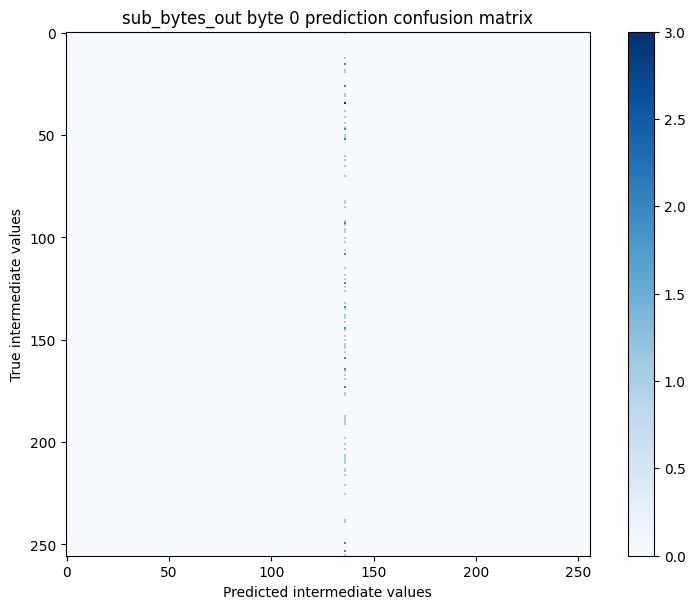

In [ ]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))


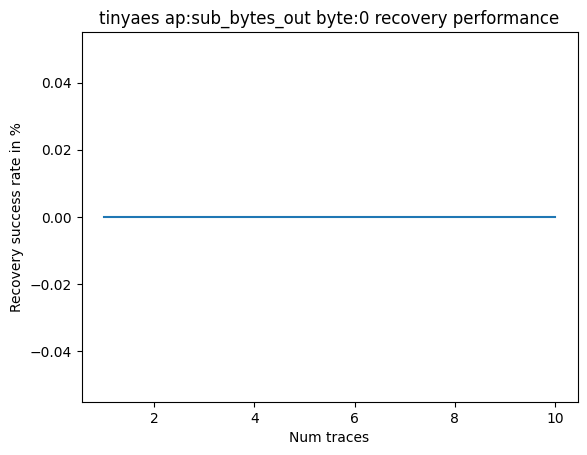

In [ ]:
NUM_TRACES_TO_PLOT = 10
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()